<a href="https://colab.research.google.com/github/Uwimbabazi-Keza/Breast-Cancer-Prediction-Model/blob/main/Transfer_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Load dataset

In [21]:
df_dir = "/content/drive/MyDrive/Dataset_BUSI_with_GT"
directory = ["benign", "malignant", "normal"]

In [22]:
image_paths, labels, mask_paths = [], [], []

for dir in directory:
    files = os.listdir(os.path.join(df_dir, dir))
    for file in files:
        if "mask" in file:
            continue
        else:
            image_paths.append(os.path.join(df_dir, dir, file))
            labels.append(dir)

In [23]:
df = pd.DataFrame({"image_path": image_paths, "label": labels})

In [24]:
label_mapping = {'benign': 0, 'malignant': 1, 'normal': 2}
df['label'] = df['label'].map(label_mapping)

In [25]:
def load_image(path):
    img = load_img(path, target_size=(128, 128), color_mode='grayscale')
    image_array = img_to_array(img)
    image_array /= 255.0
    return image_array

images = []

for image_path in tqdm(image_paths):
    image = load_image(image_path)
    images.append(image)

images = np.array(images)
labels = np.array(df['label'])

100%|██████████| 780/780 [00:26<00:00, 29.97it/s]


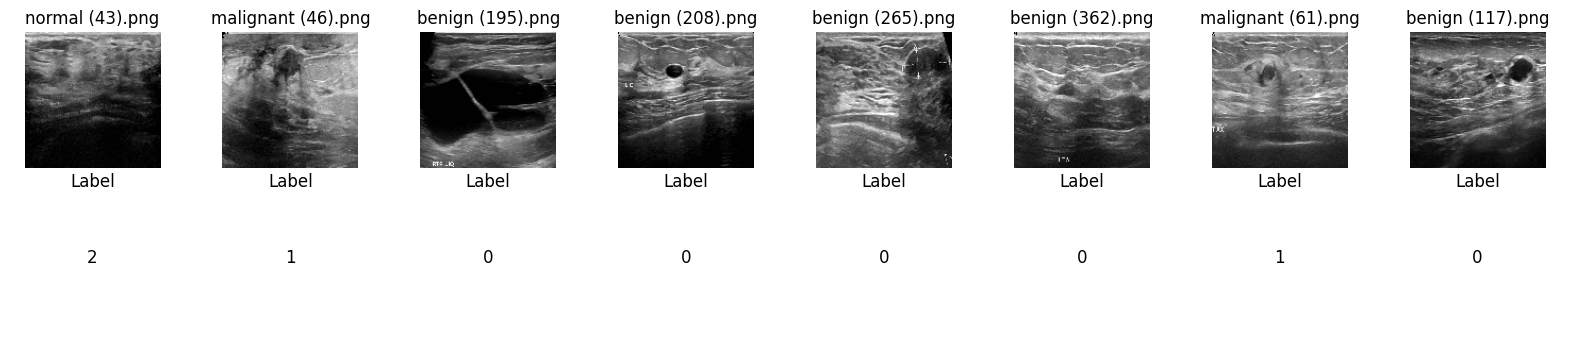

In [26]:
def plot_image_and_mask(images, labels):
    plt.figure(figsize=(20, 6))

    for i in range(8):
        idx = np.random.randint(len(images))
        plt.subplot(3, 8, i + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
        plt.title(image_paths[idx].split("/")[-1])

        plt.subplot(3, 8, i + 9)
        plt.text(0.5, 0.5, str(labels[idx]), fontsize=12, ha='center')
        plt.axis("off")
        plt.title("Label")

    plt.show()

plot_image_and_mask(images, labels)

In [27]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

## Build base model

In [28]:
def build_model(base_model):
    base_model.trainable = False
    inputs = layers.Input(shape=(128, 128, 1))
    x = layers.Conv2D(3, (3, 3), padding="same")(inputs)  # Convert grayscale to RGB
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation='softmax')(x)  # 3 classes: benign, malignant, normal
    model = Model(inputs, outputs)
    return model

## VGG16, ResNet50, InceptionV3 models



In [29]:
vgg_model = build_model(VGG16(weights='imagenet', include_top=False))
resnet_model = build_model(ResNet50(weights='imagenet', include_top=False))
inception_model = build_model(InceptionV3(weights='imagenet', include_top=False))


In [30]:
#Compile the models
vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
inception_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
#Train the models
history_vgg = vgg_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)
history_resnet = resnet_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)
history_inception = inception_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
22/22 [==============================] - 395s 18s/step - loss: 1.0419 - accuracy: 0.5285 - val_loss: 0.9110 - val_accuracy: 0.5128
Epoch 2/10
22/22 [==============================] - 392s 18s/step - loss: 0.8738 - accuracy: 0.6211 - val_loss: 0.7884 - val_accuracy: 0.6667
Epoch 3/10
22/22 [==============================] - 387s 18s/step - loss: 0.8221 - accuracy: 0.6368 - val_loss: 0.7361 - val_accuracy: 0.6667
Epoch 4/10
22/22 [==============================] - 390s 18s/step - loss: 0.7807 - accuracy: 0.6553 - val_loss: 0.6970 - val_accuracy: 0.7821
Epoch 5/10
22/22 [==============================] - 382s 17s/step - loss: 0.7393 - accuracy: 0.6823 - val_loss: 0.6633 - val_accuracy: 0.7051
Epoch 6/10
22/22 [==============================] - 388s 18s/step - loss: 0.7106 - accuracy: 0.6966 - val_loss: 0.6195 - val_accuracy: 0.7564
Epoch 7/10
22/22 [==============================] - 386s 18s/step - loss: 0.6754 - accuracy: 0.7151 - val_loss: 0.5723 - val_accuracy: 0.8590
Epoch 

In [41]:
# Evaluation
vgg_eval = vgg_model.evaluate(X_test, y_test)
resnet_eval = resnet_model.evaluate(X_test, y_test)
inception_eval = inception_model.evaluate(X_test, y_test)

#Prediction
y_pred_vgg = np.argmax(vgg_model.predict(X_test), axis=-1)
y_pred_resnet = np.argmax(resnet_model.predict(X_test), axis=-1)
y_pred_inception = np.argmax(inception_model.predict(X_test), axis=-1)

3/3 [==============================] - 3s 1s/step


In [42]:
#Reports
from sklearn.metrics import classification_report
print("VGG16 Classification Report")
print(classification_report(y_test, y_pred_vgg, target_names=label_mapping.keys()))

print("ResNet50 Classification Report")
print(classification_report(y_test, y_pred_resnet, target_names=label_mapping.keys()))

print("InceptionV3 Classification Report")
print(classification_report(y_test, y_pred_inception, target_names=label_mapping.keys()))

VGG16 Classification Report
              precision    recall  f1-score   support

      benign       0.72      0.97      0.83        39
   malignant       0.90      0.78      0.84        23
      normal       1.00      0.31      0.48        16

    accuracy                           0.78        78
   macro avg       0.87      0.69      0.71        78
weighted avg       0.83      0.78      0.76        78

ResNet50 Classification Report
              precision    recall  f1-score   support

      benign       0.74      0.79      0.77        39
   malignant       0.61      0.87      0.71        23
      normal       0.67      0.12      0.21        16

    accuracy                           0.68        78
   macro avg       0.67      0.60      0.56        78
weighted avg       0.68      0.68      0.64        78

InceptionV3 Classification Report
              precision    recall  f1-score   support

      benign       0.73      0.95      0.82        39
   malignant       0.79      0.65   

In [38]:
models = {'VGG16': vgg_model, 'ResNet50': resnet_model, 'InceptionV3': inception_model}
evaluation_results = {}

## Precision, Recall, F1 Score

In [40]:
print("Evaluation Results:")
print("Model\t\tAccuracy\tPrecision\tRecall\t\tF1 Score")
for model, results in evaluation_results.items():
    accuracy, precision, recall, f1 = results
    print(f"{model}\t{accuracy:.2f}\t\t{precision:.2f}\t\t{recall:.2f}\t\t{f1:.2f}")

Evaluation Results:
Model		Accuracy	Precision	Recall		F1 Score


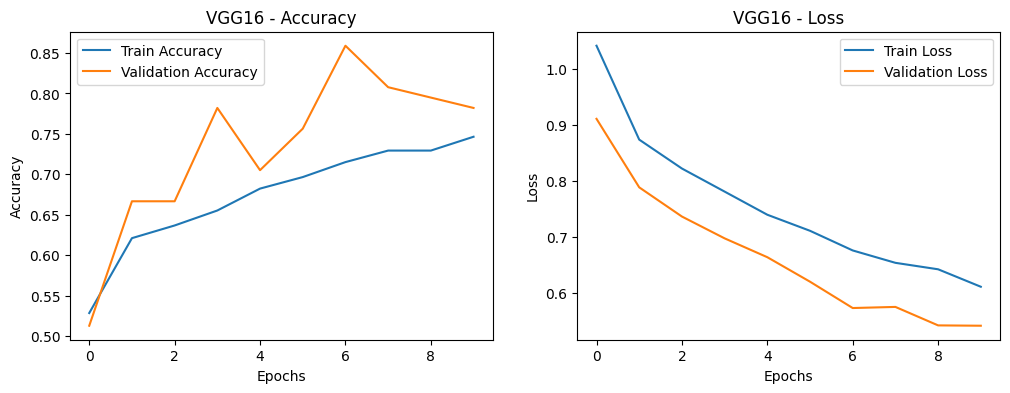

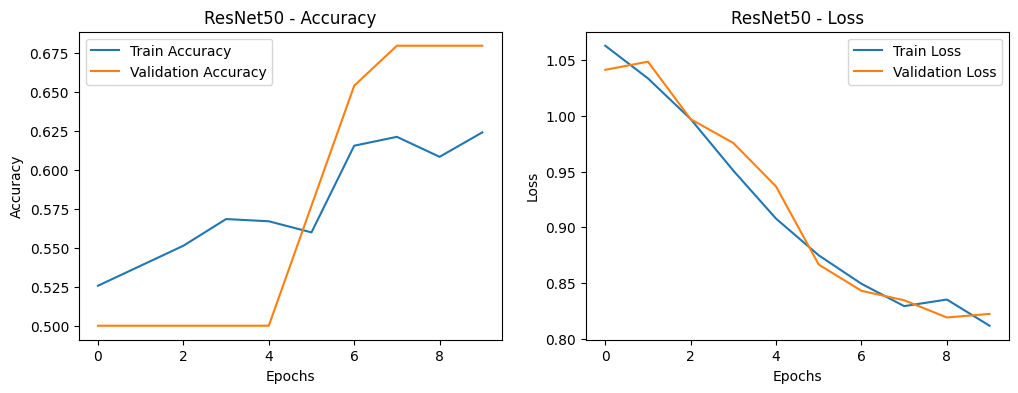

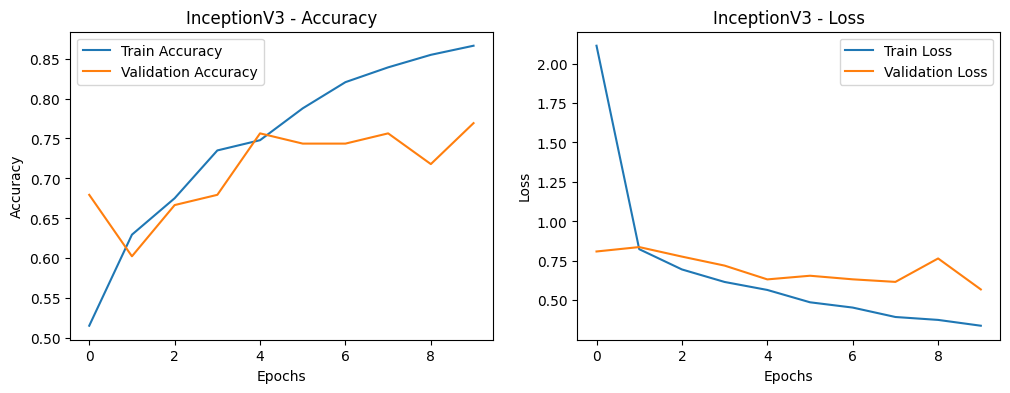

In [33]:
# Plotting the Results
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history_vgg, 'VGG16')
plot_training_history(history_resnet, 'ResNet50')
plot_training_history(history_inception, 'InceptionV3')